In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

import pickle


## Check the data

In [56]:
df = pd.read_csv("../data/HistoricalPrices.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True, ascending=True)
df.head()

,Open,High,Low,Close
Date,,,,
2012-07-31,1385.27,1387.16,1379.17,1379.32
2012-08-01,1379.32,1385.03,1373.35,1375.14
2012-08-02,1375.13,1375.13,1354.65,1365.00
2012-08-03,1365.45,1394.16,1365.45,1390.99
2012-08-06,1391.04,1399.63,1391.04,1394.23


In [100]:
all_stock = pd.read_csv('../data/all_stocks_5yr.csv')
all_stock.head()
all_stock['date'] = pd.to_datetime(all_stock['date'])
all_stock.set_index('date', inplace=True)
all_stock.sort_index(inplace=True)
all_stock.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.1200,14.630,14.75,8407500,AAL
2013-02-08,81.22,81.9300,80.940,81.89,296853,SLG
2013-02-08,78.24,79.0700,78.125,79.07,4632684,SLB
2013-02-08,236.64,238.6924,235.750,238.16,552207,BLK
2013-02-08,89.04,89.4800,88.910,89.16,554948,SJM


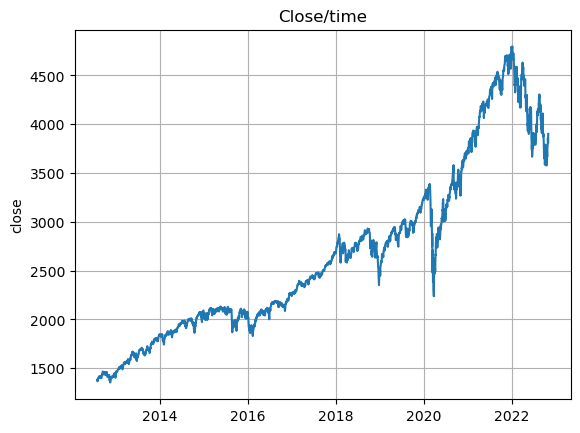

In [57]:
fig, ax = plt.subplots()
ax.plot(df["Close"])

ax.set(ylabel='close',
       title='Close/time')
ax.grid()

plt.show()

check for missing values

In [58]:
# No missing values, we can continue safely
print(df.isnull().sum())

Open     0
High     0
Low      0
Close    0
dtype: int64


# Data Engineering

In [59]:
df["return"] = df["Close"].pct_change()
df.head()

,Open,High,Low,Close,return
Date,,,,,
2012-07-31,1385.27,1387.16,1379.17,1379.32,NaN
2012-08-01,1379.32,1385.03,1373.35,1375.14,-0.003030
2012-08-02,1375.13,1375.13,1354.65,1365.00,-0.007374
2012-08-03,1365.45,1394.16,1365.45,1390.99,0.019040
2012-08-06,1391.04,1399.63,1391.04,1394.23,0.002329


In [60]:
# add n column to the df, where each added column is the return lagged
# the function returns the new features names
def lag_returns(df, n) -> list[str]:
    
    for i in range(1,n+1):
        df["return_lagged_by_"+str(i)] = df["return"].shift(i)
    
    return ["return_lagged_by_"+str(i) for i in range(1,n+1)]

In [61]:
features_names = lag_returns(df, 2)
print(features_names)
df.head()

['return_lagged_by_1', 'return_lagged_by_2']


,Open,High,Low,Close,return,return_lagged_by_1,return_lagged_by_2
Date,,,,,,,
2012-07-31,1385.27,1387.16,1379.17,1379.32,NaN,NaN,NaN
2012-08-01,1379.32,1385.03,1373.35,1375.14,-0.003030,NaN,NaN
2012-08-02,1375.13,1375.13,1354.65,1365.00,-0.007374,-0.003030,NaN
2012-08-03,1365.45,1394.16,1365.45,1390.99,0.019040,-0.007374,-0.003030
2012-08-06,1391.04,1399.63,1391.04,1394.23,0.002329,0.019040,-0.007374


In [62]:
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,return,return_lagged_by_1,return_lagged_by_2
Date,,,,,,,
2012-08-03,1365.45,1394.16,1365.45,1390.99,0.019040,-0.007374,-0.003030
2012-08-06,1391.04,1399.63,1391.04,1394.23,0.002329,0.019040,-0.007374
2012-08-07,1394.46,1407.14,1394.46,1401.35,0.005107,0.002329,0.019040
2012-08-08,1401.23,1404.14,1396.13,1402.22,0.000621,0.005107,0.002329
2012-08-09,1402.26,1405.95,1398.80,1402.80,0.000414,0.000621,0.005107


In [63]:
df["variation"] = (df["return"] > 0).astype(int)
df["variation"].value_counts()

variation
1    1400
0    1177
Name: count, dtype: int64

# Define features/target

In [64]:
X = df[features_names]
y = df["variation"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

## models

Linear Regression

In [65]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [66]:

X_test["prediction"] = model.predict(X_test)
X_test["return"] = df["return"][X_test.index[0]:]


prediction
0    418
1    356
Name: count, dtype: int64


<AxesSubplot:xlabel='Date'>

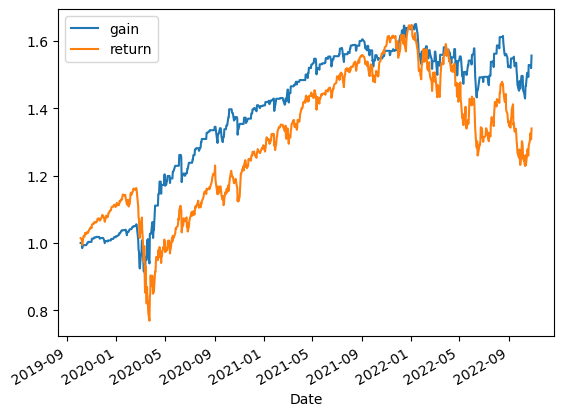

In [67]:
print(X_test["prediction"].value_counts())
X_test["gain"] = X_test["prediction"] * X_test["return"]
(X_test[["gain", "return"]] + 1).cumprod().plot()



time series split

In [68]:

from sklearn.model_selection import TimeSeriesSplit

n_splits = 5
time_series_split = TimeSeriesSplit(n_splits=n_splits) 

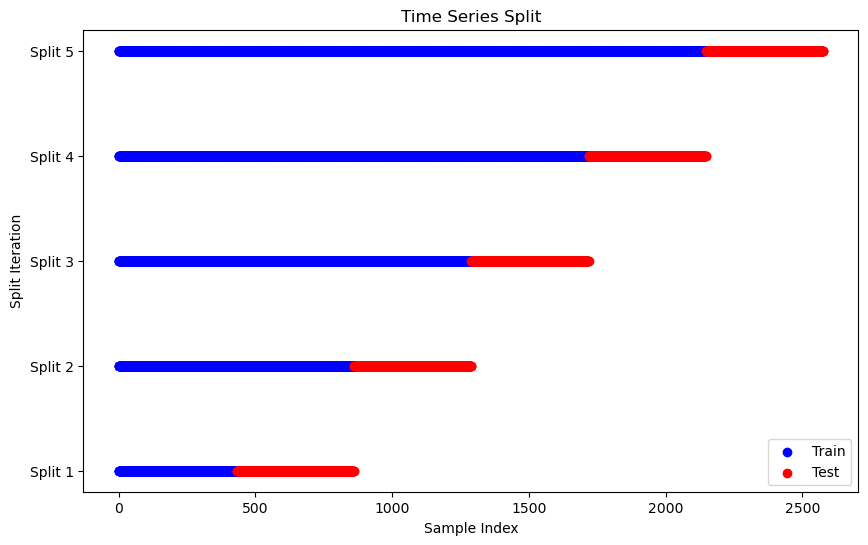

In [69]:
# plot the time serie split
def plotTimeSeriesSplit(split, n_splits):
    
    plt.figure(figsize=(10, 6))
    for i, (train_index, test_index) in enumerate(split, 1):
        plt.scatter(train_index, [i] * len(train_index), color='blue', label='Train' if i == 1 else None)
        plt.scatter(test_index, [i] * len(test_index), color='red', label='Test' if i == 1 else None)

    # Add labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Split Iteration')
    plt.title('Time Series Split')
    plt.legend()
    plt.yticks(range(1, n_splits + 1), ['Split {}'.format(i) for i in range(1, n_splits + 1)])

    # Show plot
    plt.show()
    
plotTimeSeriesSplit(time_series_split.split(X), n_splits)

block series split

In [70]:
# return an array of array, where each sub-array is a block separated into a test set and a train set
# e.g : blockSplit(X,y,n_splits=n) will return this 
# [[train1, test1], [train2,test2], ... [train_n, test_n]]
 
def blockSplit(X,y,n_splits=5, test_size=0.2):
    block_split = []
    block_size = int(len(X)/n_splits)
    indexes = [x*block_size for x in range(0,n_splits+1)]

    for i in range(len(indexes)-1):
        block = X.iloc[indexes[i]:indexes[i+1]]
        print(test_size * len(block))
        split_index = int(test_size * len(block))
        block_split.append([block[split_index:], block[:split_index]]) 
    
    return block_split
        


data = X
data["prediction"] = y
block_split = blockSplit(X,y, n_splits=5, test_size=0.3)

print("TRAIN : " ,len(block_split[0][0]))
print("TEST : ", len(block_split[0][1]))
    

154.5
154.5
154.5
154.5
154.5
TRAIN :  361
TEST :  154


/tmp/ipykernel_11981/3452156224.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction"] = y


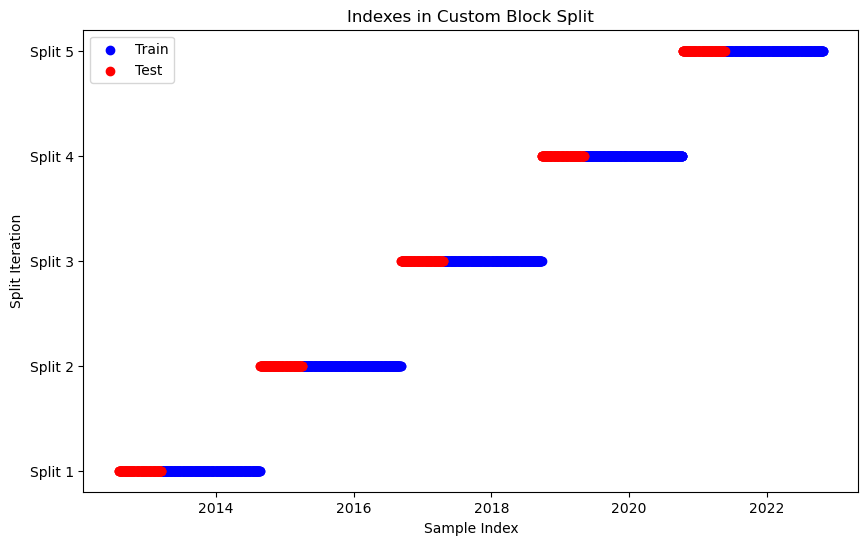

In [71]:
# Plot the indexes
plt.figure(figsize=(10, 6))
for i, (train, test) in enumerate(block_split, 1):
    train_index = train.index
    test_index = test.index
    plt.scatter(train_index, [i] * len(train_index), color='blue', label='Train' if i == 1 else None)
    plt.scatter(test_index, [i] * len(test_index), color='red', label='Test' if i == 1 else None)

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Split Iteration')
plt.title('Indexes in Custom Block Split')
plt.legend()
plt.yticks(range(1, len(block_split) + 1), ['Split {}'.format(i) for i in range(1, len(block_split) + 1)])

# Show plot
plt.show()

In [72]:
X.drop("prediction", axis=1 ,inplace=True)
X.head()


/tmp/ipykernel_11981/3413567672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop("prediction", axis=1 ,inplace=True)


,return_lagged_by_1,return_lagged_by_2
Date,,
2012-08-03,-0.007374,-0.003030
2012-08-06,0.019040,-0.007374
2012-08-07,0.002329,0.019040
2012-08-08,0.005107,0.002329
2012-08-09,0.000621,0.005107


In [73]:
y.value_counts()

variation
1    1400
0    1177
Name: count, dtype: int64

# Grid Search Cross Validation

In [74]:
model = RandomForestRegressor()

# grid search parameters
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(1,14))}]
metrics = {"AUC": "roc_auc"}


#gridsearch = GridSearchCV(model, forest_params, cv = 10, scoring=['accuracy', 'roc_auc'])
gridsearch = GridSearchCV(
    model,
    forest_params,
    scoring=metrics,
    refit="AUC",
    n_jobs=2,
    cv=10,
    error_score='raise',
    return_train_score=True,
)
gridsearch.fit(X,y)

print('best estimator : ', gridsearch.best_estimator_)
print('best params : ', gridsearch.best_params_)
print('best score : ', gridsearch.best_score_)
print('cross-validation results : ', gridsearch.cv_results_)

# save the results


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best estimator :  RandomForestRegressor(max_depth=10, max_features=6)
best params :  {'max_depth': 10, 'max_features': 6}
best score :  0.5132201964129558
cross-validation results :  {'mean_fit_time': array([0.18114429, 0.28298457, 0.28362479, 0.28740568, 0.28774233,
       0.2829335 , 0.28531907, 0.28929875, 0.288239  , 0.28909063,
       0.2943748 , 0.30937488, 0.3109195 , 0.20347555, 0.31700778,
       0.31467412, 0.31556253, 0.31030309, 0.30591471, 0.30555098,
       0.30868123, 0.30579145, 0.30376766, 0.30300493, 0.31169493,
       0.30292511, 0.2042789 , 0.3240447 , 0.32180908, 0.33341191,
       0.34360797, 0.33077669, 0.33394754, 0.32423596, 0.32393892,
       0.33059058, 0.32465053, 0.32702553, 0.32965035, 0.24617565,
       0.33844457, 0.34684985, 0.33788686, 0.33833768, 0.33928721,
       0.37081068, 0.35707638, 0.36227431, 0.3521085 , 0.34018741,
       0.34294188, 0.34741945, 0.22468009, 0.34671736, 0.34628322,
       0.34060194, 0.34675856, 0.34763908, 0.35007601, 0.34457

In [85]:
# store the auc result in a dataframe

folds = {}
indexes = []
for i, (train, test) in enumerate(block_split):
    indexes.append(("fold_"+str(i), "train"))
    indexes.append(("fold_"+str(i), "test"))

    folds["train_"+str(i)] = i # replace i by the auc
    folds["test_"+str(i)] = i

indexes_pd = pd.MultiIndex.from_tuples(indexes, names=["set", "AUC"])

df = pd.DataFrame(folds, index=indexes)
df.head()    



,train_0,test_0,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4
"(fold_0, train)",0,0,1,1,2,2,3,3,4,4
"(fold_0, test)",0,0,1,1,2,2,3,3,4,4
"(fold_1, train)",0,0,1,1,2,2,3,3,4,4
"(fold_1, test)",0,0,1,1,2,2,3,3,4,4
"(fold_2, train)",0,0,1,1,2,2,3,3,4,4


In [75]:
result = gridsearch.cv_results_
print(result.keys())
print(len(result["mean_train_AUC"]))
print(X.shape)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'split5_test_AUC', 'split6_test_AUC', 'split7_test_AUC', 'split8_test_AUC', 'split9_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'split5_train_AUC', 'split6_train_AUC', 'split7_train_AUC', 'split8_train_AUC', 'split9_train_AUC', 'mean_train_AUC', 'std_train_AUC'])
65
(2577, 2)


In [76]:
pickle.dump(gridsearch.best_estimator_, open("../results/best_estimator.pkl", "wb"))